In [1]:
import numpy as np
import pandas as pd 
import warnings
import pickle
import wandb
import time
import tqdm

In [2]:
your_sweep_ids = [
    'scpfzqmy', # bp sine dropout
    'fz96ok67', # pc sine dropout
    'rh172h74', # bp mnist dropout
    'mohfpec3', # pc mnist dropout
]

In [3]:
api = wandb.Api(timeout=60)
entity, project = 'the-real-dl', 'bio-transformers'

In [4]:
def extract(wandb_sweeps, maxrun=None):
    
    dfs = []
    count = 0

    for sid in wandb_sweeps:

        for i, run in enumerate(api.sweep(entity + '/' + project + '/' + sid).runs):
            # time.sleep(2) # to avoid 429 Client Error
            print(f'Fetching run #{i} ({run.sweep.name} - {run.id} - {run.state})'.ljust(100), end='\r')
            if maxrun is not None and count == maxrun: break

            summary = run.summary
            if not 'epoch' in summary.keys(): continue
            if run.state == 'running': continue
            if run.state == 'crashed': continue
            if run.state == 'failed': continue

            run_id = run.id
            sweep_id = run.sweep.id

            config = run.config
            run_df = run.history(samples=run.config['epochs'] * 4)

            config.update({'sweep-id': sweep_id, 'run-id': run_id})
            summary.update({'sweep-id': sweep_id, 'run-id': run_id})

            l_epochs = []
            l_train_loss = []
            l_test_loss = []
            l_train_energy = []
            l_gen_error = []

            for e in range(summary['epoch']):
                x = run_df[run_df.epoch == e]

                train_losses = x.train_loss.unique()
                test_losses = x.test_loss.unique()

                train_loss_no_nan = train_losses[~np.isnan(train_losses)]
                test_loss_no_nan = test_losses[~np.isnan(test_losses)]

                train_loss = train_loss_no_nan[0] if len(train_loss_no_nan) > 0 else np.nan
                test_loss = test_loss_no_nan[0] if len(test_loss_no_nan) > 0 else np.nan

                l_epochs.append(e)
                l_train_loss.append(train_loss)
                l_test_loss.append(test_loss)

                gen_errors = x.gen_error.unique()
                gen_error_no_nan = gen_errors[~np.isnan(gen_errors)]
                gen_error = gen_error_no_nan[0] if len(gen_error_no_nan) > 0 else np.nan
                l_gen_error.append(gen_error)

                if config['training'] == 'pc':
                    train_energies = x.train_energy.unique()
                    train_energy_no_nan = train_energies[~np.isnan(train_energies)]
                    train_energy = train_energy_no_nan[0] if len(train_energy_no_nan) > 0 else np.nan
                    l_train_energy.append(train_energy)

                if config['training'] == 'bp':
                    run_ids = np.full(len(l_epochs), run_id)
                    sweep_ids = np.full(len(l_epochs), sweep_id)
                    data = list(zip(sweep_ids, run_ids, l_epochs, l_train_loss, l_test_loss, l_gen_error))
                    columns = ['sweep_id', 'run_id', 'epoch', 'train_loss', 'test_loss', 'gen_error']
                else:
                    run_ids = np.full(len(l_epochs), run_id)
                    sweep_ids = np.full(len(l_epochs), sweep_id)
                    data = list(zip(sweep_ids, run_ids, l_epochs, l_train_loss, l_test_loss, l_train_energy, l_gen_error))
                    columns = ['sweep_id', 'run_id', 'epoch', 'train_loss', 'test_loss', 'train_energy', 'gen_error']

            df = pd.DataFrame(data, columns=columns)

            # adding configs to df
            for k in list(config.keys())[:-2]:
                df['c_' + str(k)] = config[k]

            # adding summary to df
            for k in summary.keys():
                if k in ['_runtime', 'train_loss', 'test_loss', 'train_energy', 'gen_error']:
                    df['f_' + str(k)] = summary[k]

            dfs.append(df)
            count += 1

    print(f'Fetched {count} runs in {entity}/{project} (max runs: {"all" if maxrun is None else maxrun})'.ljust(100))
    return pd.concat(dfs, axis=0).reset_index(drop=True)

In [25]:
def sort_per_dropdout(df):
    df = df.groupby('c_dropout').agg({'f_gen_error': np.median, 'test_loss': np.median, 'train_loss': np.median}).sort_values('f_gen_error', ascending=True).reset_index()
    return df

In [6]:
def median_over_seeds(df):
    infos = df[['sweep_id', 'c_dataset', 'c_training']].drop_duplicates().set_index('sweep_id').to_dict()
    df = df.drop(columns=[c for c in list(df.columns) if c.startswith('c') and c != 'c_dropout'])
    df = df.groupby(['sweep_id', 'c_dropout', 'epoch']).agg(np.median).reset_index()
    for k in infos.keys(): df[k] = df.apply(lambda r: infos[k][r.sweep_id], axis=1)
    return df

In [7]:
def plot_dropout_gen(df, p=None):
    assert len(df.sweep_id.unique()) == 1
    title = f'{df.c_training.unique()[0]} {df.c_dataset.unique()[0]} dropout (median over seeds)'
    p_dropout = sort_per_dropdout(df).iloc[0,0] if p is None else p

    df_dropout_0 = df[df.c_dropout == 0][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
    df_dropout_p = df[df.c_dropout == p_dropout][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')

    filt = lambda ls: (ls > np.quantile(ls, 0.01)) & (ls < np.quantile(ls, 0.99))
    df_dropout_0 = df_dropout_0[filt(df_dropout_0.gen_error)]
    df_dropout_p = df_dropout_p[filt(df_dropout_p.gen_error)]

    # ax = df_dropout_0.plot(x='epoch', y='train_loss', label=f'Train Error (p={0.0})', figsize=(10,4), title=title, linestyle='dashed', color='tab:blue')
    # ax = df_dropout_p.plot(x='epoch', y='train_loss', label=f'Train Error (p={p_dropout})', ax=ax, figsize=(10,4), title=title, linestyle='dashed', color='tab:orange')

    ax = df_dropout_0.plot(x='epoch', y='gen_error', label=f'OOD Error (p={0.0})', figsize=(10,4), color='tab:orange')
    ax = df_dropout_p.plot(x='epoch', y='gen_error', label=f'OOD Error (p={p_dropout})', ax=ax, figsize=(10,4),  color='tab:blue')

In [8]:
def plot_dropout_test(df, p=None):
    assert len(df.sweep_id.unique()) == 1
    title = f'{df.c_training.unique()[0]} {df.c_dataset.unique()[0]} dropout (median over seeds)'
    p_dropout = sort_per_dropdout(df).iloc[0,0] if p is None else p

    df_dropout_0 = df[df.c_dropout == 0][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
    df_dropout_p = df[df.c_dropout == p_dropout][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')

    filt = lambda ls: (ls > np.quantile(ls, 0.01)) & (ls < np.quantile(ls, 0.99))
    df_dropout_0 = df_dropout_0[filt(df_dropout_0.test_loss)]
    df_dropout_p = df_dropout_p[filt(df_dropout_p.test_loss)]

    # ax = df_dropout_0.plot(x='epoch', y='train_loss', label=f'Train Error (p={0.0})', figsize=(10,4), title=title, linestyle='dashed', color='tab:blue')
    # ax = df_dropout_p.plot(x='epoch', y='train_loss', label=f'Train Error (p={p_dropout})', ax=ax, figsize=(10,4), title=title, linestyle='dashed', color='tab:orange')

    ax = df_dropout_0.plot(x='epoch', y='test_loss', label=f'Test Error (p={0.0})', figsize=(10,4), color='tab:orange')
    ax = df_dropout_p.plot(x='epoch', y='test_loss', label=f'Test Error (p={p_dropout})', ax=ax, figsize=(10,4),  color='tab:blue')

In [9]:
def plot_dropout_train(df, p=None):
    assert len(df.sweep_id.unique()) == 1
    title = f'{df.c_training.unique()[0]} {df.c_dataset.unique()[0]} dropout (median over seeds)'
    p_dropout = sort_per_dropdout(df).iloc[0,0] if p is None else p

    df_dropout_0 = df[df.c_dropout == 0][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
    df_dropout_p = df[df.c_dropout == p_dropout][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')

    filt = lambda ls: (ls > np.quantile(ls, 0.01)) & (ls < np.quantile(ls, 0.99))
    df_dropout_0 = df_dropout_0[filt(df_dropout_0.train_loss)]
    df_dropout_p = df_dropout_p[filt(df_dropout_p.train_loss)]

    # ax = df_dropout_0.plot(x='epoch', y='train_loss', label=f'Train Error (p={0.0})', figsize=(10,4), title=title, linestyle='dashed', color='tab:blue')
    # ax = df_dropout_p.plot(x='epoch', y='train_loss', label=f'Train Error (p={p_dropout})', ax=ax, figsize=(10,4), title=title, linestyle='dashed', color='tab:orange')

    ax = df_dropout_0.plot(x='epoch', y='train_loss', label=f'p={0.0} Test Error', figsize=(10,4), color='tab:orange')
    ax = df_dropout_p.plot(x='epoch', y='train_loss', label=f'p={p_dropout} Test Error', ax=ax, figsize=(10,4),  color='tab:blue')

In [ ]:
def plot_scatter_dropout(df):
    plt.scatter(x=)

In [10]:
df = extract(your_sweep_ids, maxrun=None)
df.to_csv('runs/dropout-wandb-runs.csv')
df_med = median_over_seeds(df)

Fetched 184 runs in the-real-dl/bio-transformers (max runs: all)                                    


In [11]:
df_bp_sine = df_med[df_med.sweep_id == 'scpfzqmy']
df_pc_sine = df_med[df_med.sweep_id == 'fz96ok67']
df_bp_mnist = df_med[df_med.sweep_id == 'rh172h74']
df_pc_mnist = df_med[df_med.sweep_id == 'mohfpec3']

In [26]:
sort_per_dropdout(df_bp_sine)

,c_dropout,f_gen_error,test_loss,train_loss
0,0.7,0.243961,0.200468,0.303402
1,0.8,0.253469,0.264881,0.353386
2,0.1,0.261646,0.116665,0.156349
3,0.6,0.264574,0.171029,0.269493
4,0.5,0.271567,0.162347,0.253016
5,0.4,0.290264,0.160955,0.250877
6,0.3,0.304076,0.155279,0.240632
7,0.9,0.315949,0.347030,0.414927
8,0.2,0.323447,0.120677,0.166393
9,0.0,0.394304,0.030175,0.031681


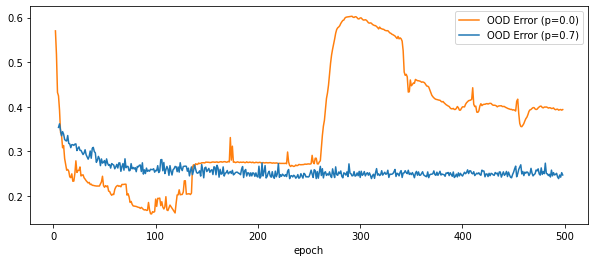

In [13]:
plot_dropout_gen(df_bp_sine)

In [14]:
sort_per_dropdout(df_pc_sine)

,c_dropout,f_gen_error,test_loss
0,0.4,0.139614,0.193192
1,0.5,0.144614,0.219406
2,0.6,0.163455,0.270751
3,0.0,0.163744,0.149545
4,0.7,0.269166,0.333302
5,0.3,0.276681,0.165695
6,0.1,0.302389,0.159376
7,0.8,0.325384,0.367442
8,0.9,0.415971,0.512707
9,0.2,0.502060,0.140984


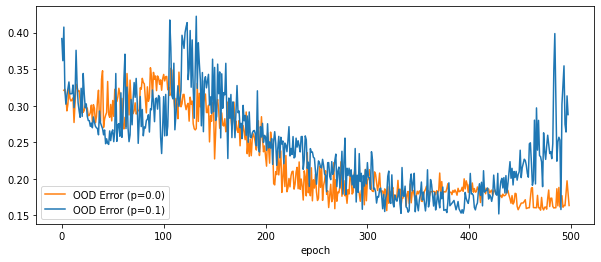

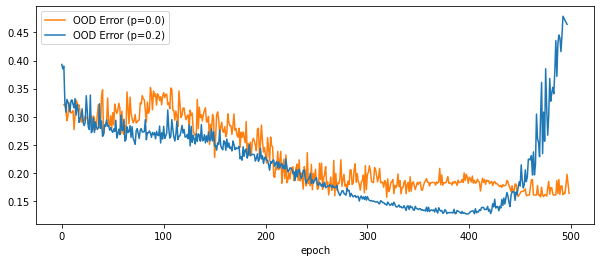

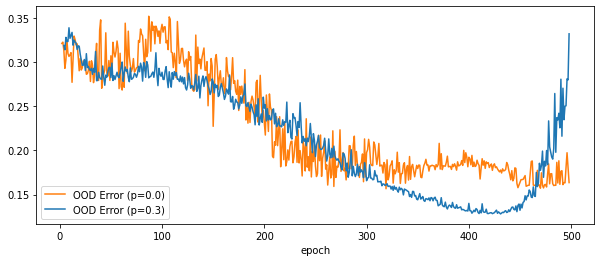

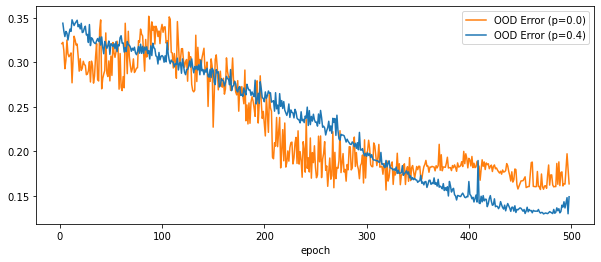

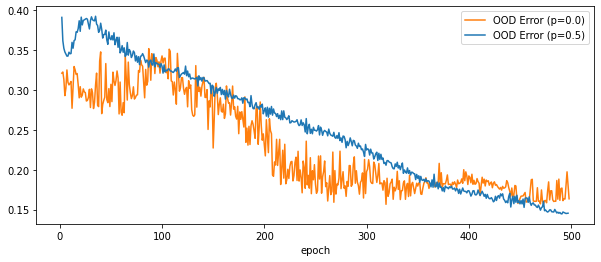

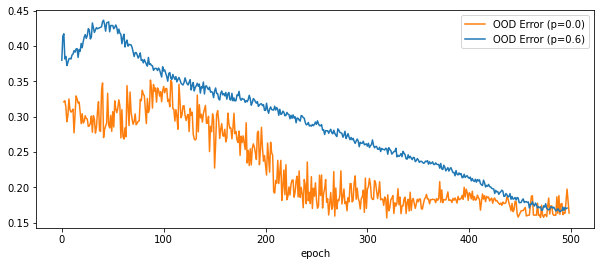

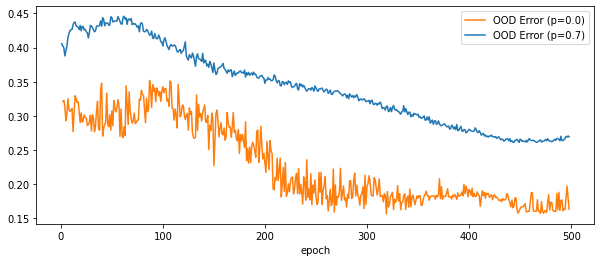

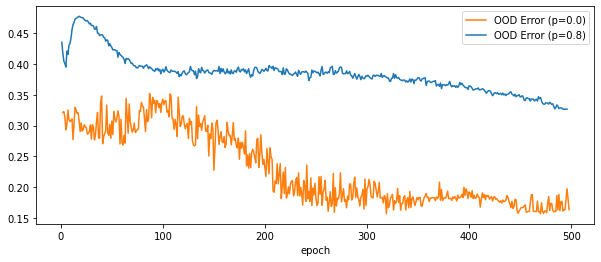

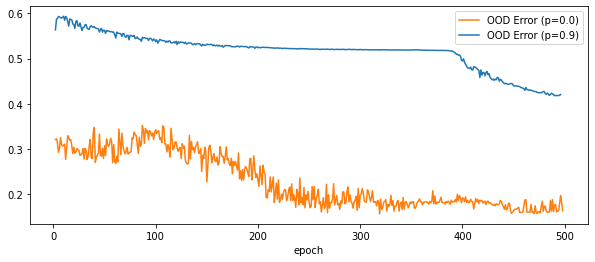

In [15]:
for p in range(1, 10):
    plot_dropout_gen(df_pc_sine, p/10)

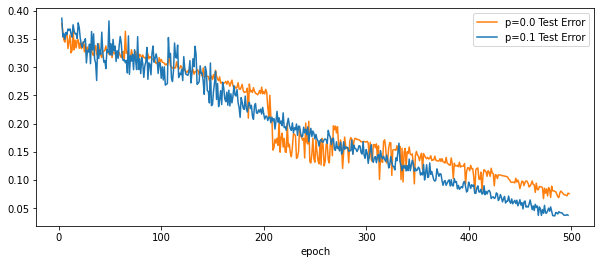

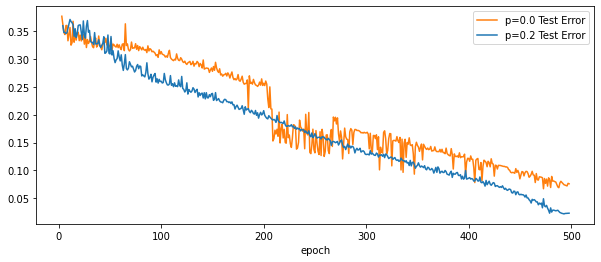

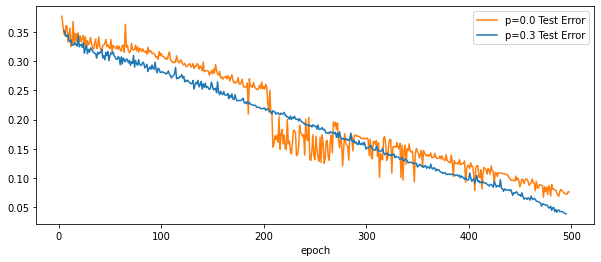

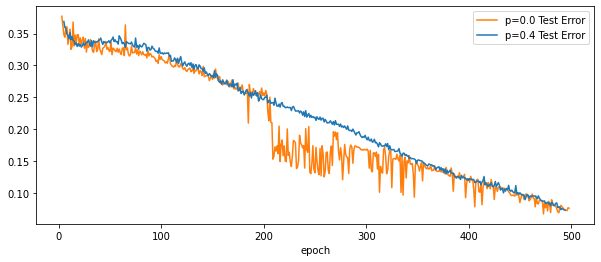

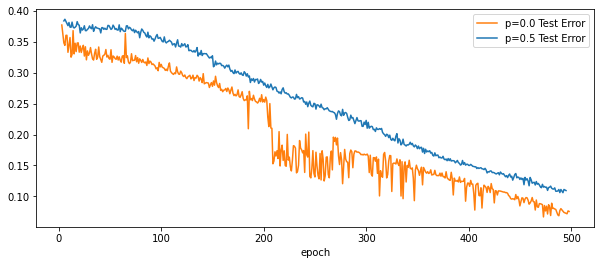

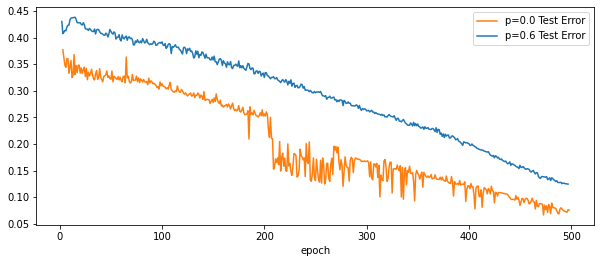

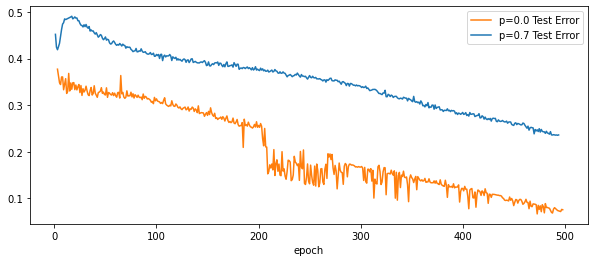

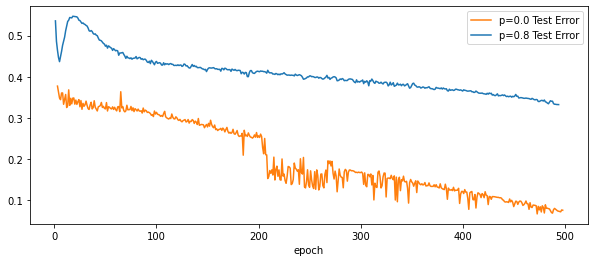

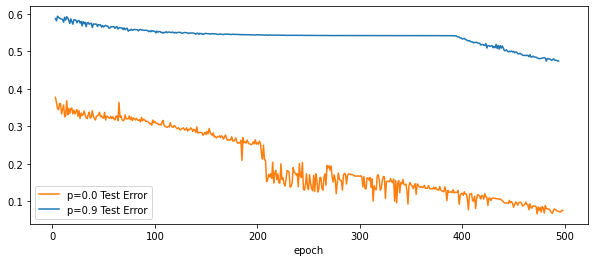

In [16]:
for p in range(1, 10):
    plot_dropout_train(df_pc_sine, p/10)

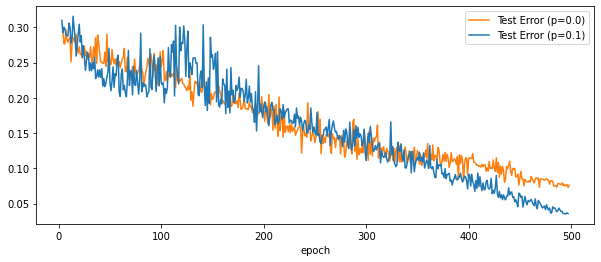

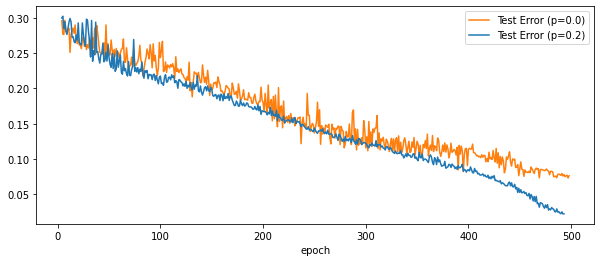

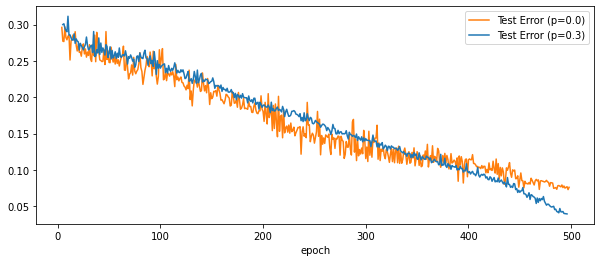

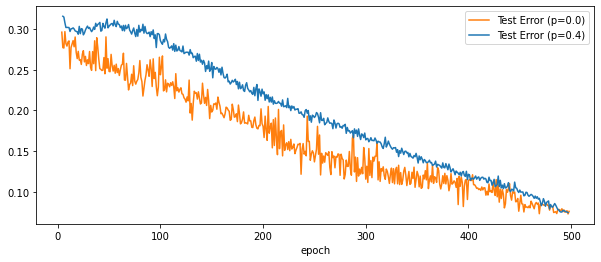

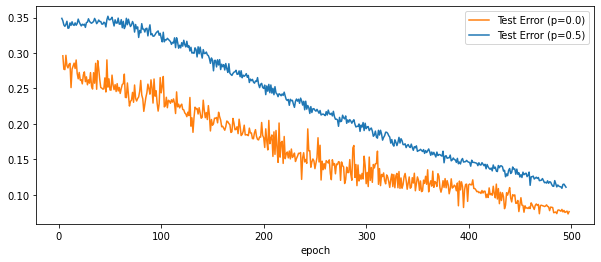

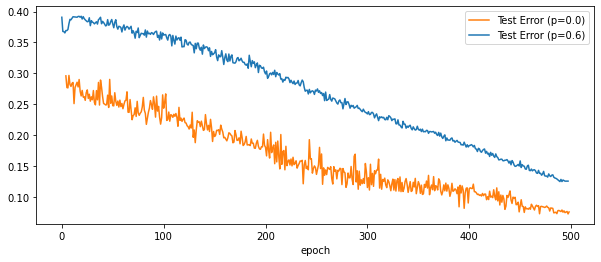

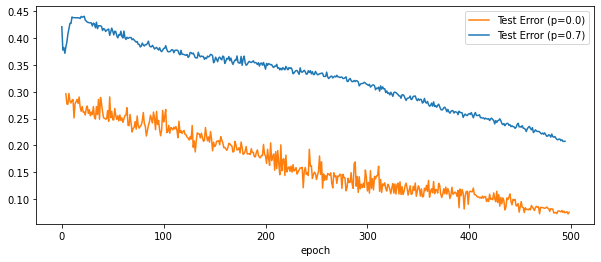

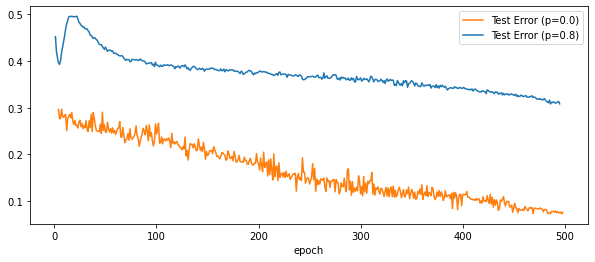

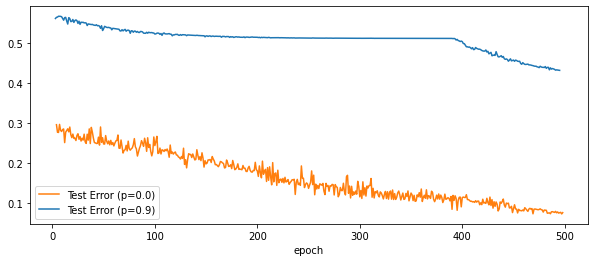

In [17]:
for p in range(1, 10):
    plot_dropout_test(df_pc_sine, p/10)

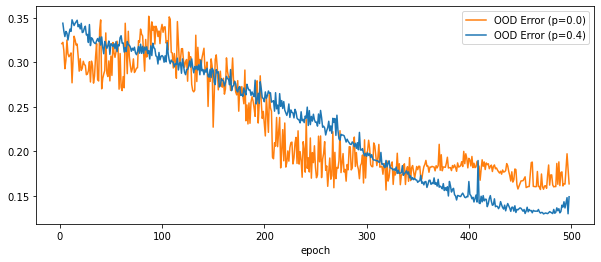

In [18]:
plot_dropout_gen(df_pc_sine)

In [19]:
sort_per_dropdout(df_bp_mnist)

,c_dropout,f_gen_error,test_loss
0,0.1,1.518279,0.070221
1,0.0,1.686449,0.070294
2,0.2,1.706457,0.080992
3,0.9,1.807596,1.108621
4,0.3,1.877544,0.095499
5,0.4,2.207121,0.118011
6,0.5,2.415392,0.148062
7,0.8,2.499745,0.494131
8,0.6,2.588191,0.188568
9,0.7,2.839195,0.271430


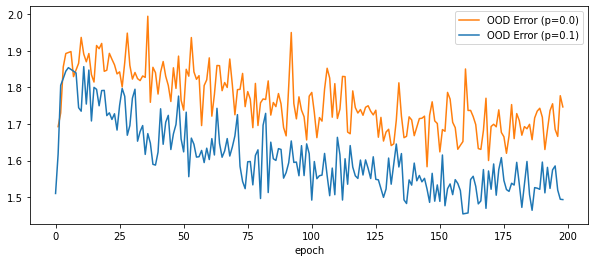

In [20]:
plot_dropout_gen(df_bp_mnist)

In [21]:
sort_per_dropdout(df_pc_mnist)

,c_dropout,f_gen_error,test_loss
0,0.0,1.592544,0.082799
1,0.1,1.613526,0.081861
2,0.9,1.665140,1.068288
3,0.2,1.795063,0.096428
4,0.8,2.016738,0.457627
5,0.3,2.073669,0.116595
6,0.4,2.311251,0.151916
7,0.7,2.600196,0.312737
8,0.6,2.671174,0.260941
9,0.5,2.730478,0.198835


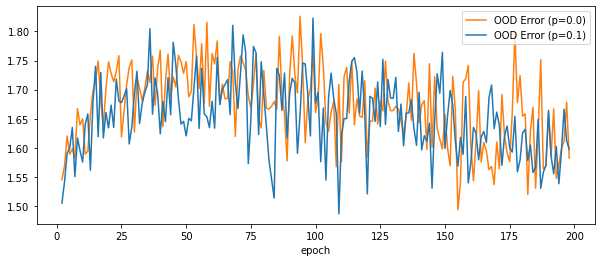

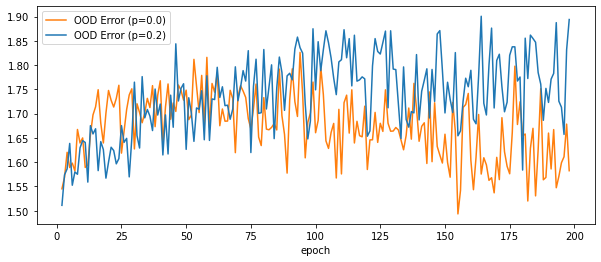

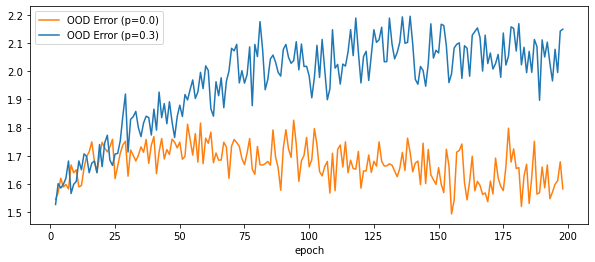

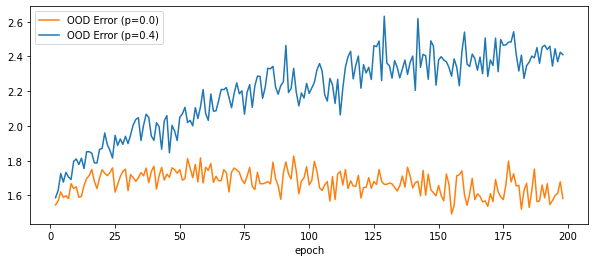

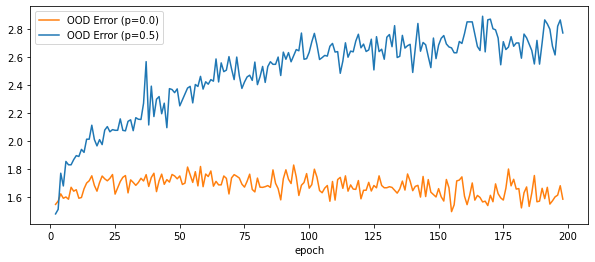

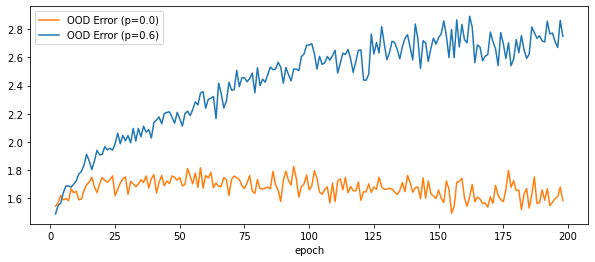

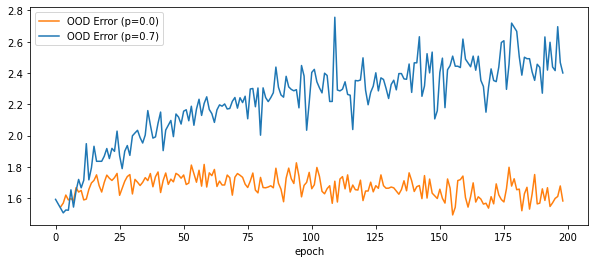

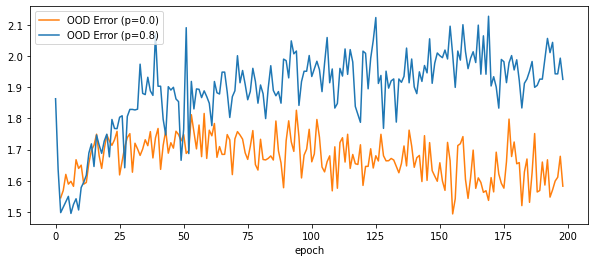

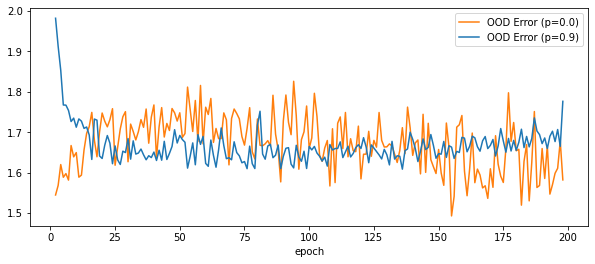

In [22]:
for p in range(1, 10):
    plot_dropout_gen(df_pc_mnist, p/10)

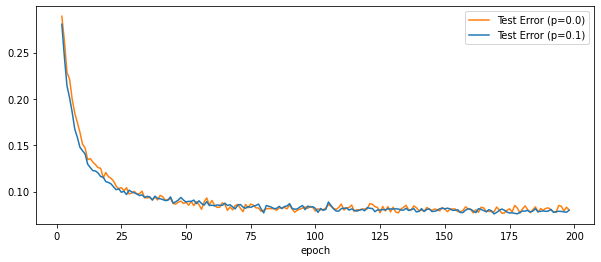

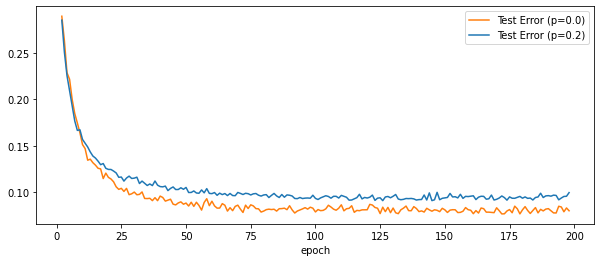

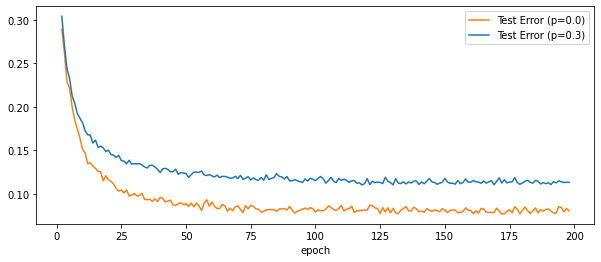

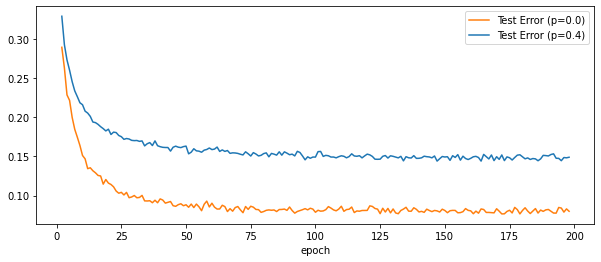

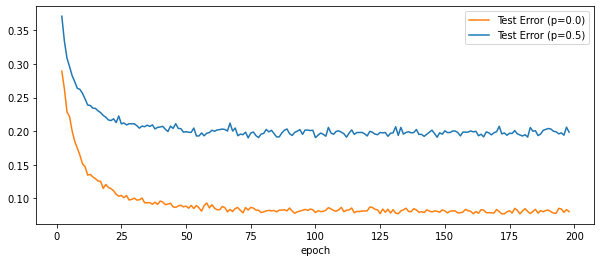

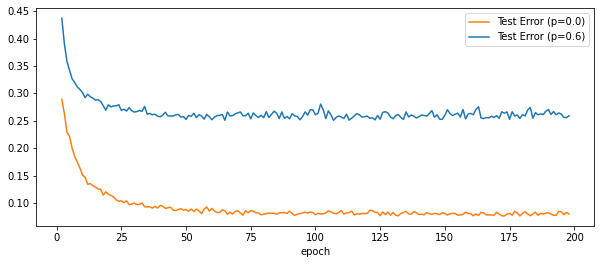

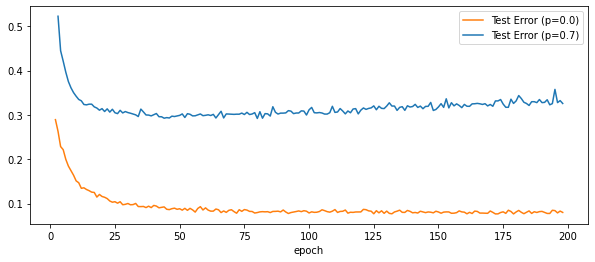

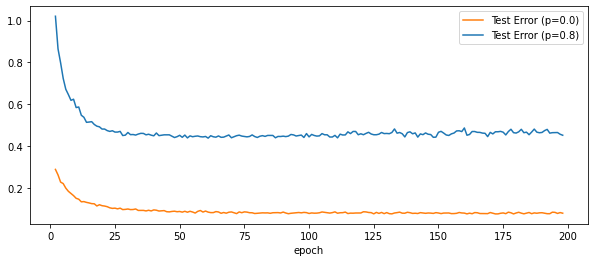

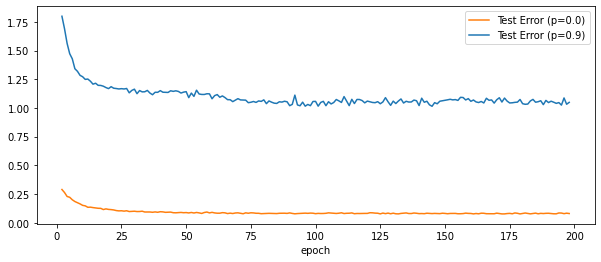

In [23]:
for p in range(1, 10):
    plot_dropout_test(df_pc_mnist, p/10)

In [32]:
df_bp_sine_dropout = sort_per_dropdout(df_bp_sine)
df_pc_sine_dropout = sort_per_dropdout(df_pc_sine)

In [45]:
df_bp_mnist_dropout = sort_per_dropdout(df_bp_mnist)
df_pc_mnist_dropout = sort_per_dropdout(df_pc_mnist)

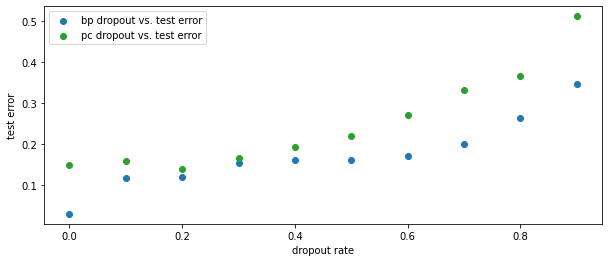

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.scatter(x=df_bp_sine_dropout.c_dropout, y=df_bp_sine_dropout.test_loss, label='bp dropout vs. test error', color='tab:blue')
plt.scatter(x=df_pc_sine_dropout.c_dropout, y=df_pc_sine_dropout.test_loss, label='pc dropout vs. test error', color='tab:green')
plt.xlabel('dropout rate')
plt.ylabel('test error')
plt.legend()

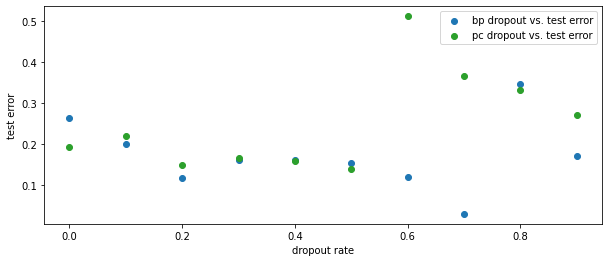

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.scatter(x=df_bp_mnist_dropout.c_dropout, y=df_bp_sine_dropout.test_loss, label='bp dropout vs. test error', color='tab:blue')
plt.scatter(x=df_pc_mnist_dropout.c_dropout, y=df_pc_sine_dropout.test_loss, label='pc dropout vs. test error', color='tab:green')
plt.xlabel('dropout rate')
plt.ylabel('test error')
plt.legend()